In [4]:
import os
import nibabel as nib
from nilearn import image
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dipy.io.gradients import read_bvals_bvecs
from skimage import filters
import numpy as np
import nibabel as nib
import os
from scipy.ndimage import zoom
from skimage import morphology
from scipy import ndimage
from dipy.io.gradients import read_bvals_bvecs
from dipy.align.reslice import reslice

from dipy.core.gradients import gradient_table
from nipype.interfaces.fsl import BET, FAST, FLIRT
from dipy.reconst.dti import TensorModel
from dipy.reconst.dti import fractional_anisotropy


In [14]:
!pip3 install dipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
  Using cached trx_python-0.3-py3-none-any.whl.metadata (2.7 kB)
  Using cached setuptools_scm-8.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached deepdiff-7.0.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached ordered_set-4.1.0-py3-none-any.whl.metadata (5.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 274.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 188.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 189.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 201.6 kB/s eta 0:00:00a 0:00:01
Using cached trx_python-0.3-py3-none-any.whl (45 kB)
Using cached deepdiff-7.0.1-py3-none-any.whl (80 kB)
Using cached setuptools_scm-8.1.0-py3-none-any.whl (43 kB)
Using cached ordered_set-4.1.0-py3-none-any.whl (7.6 kB)


In [3]:
!pip3 install nipype

  Using cached nipype-1.8.6-py3-none-any.whl.metadata (6.6 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached prov-2.0.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached rdflib-7.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached etelemetry-0.3.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached looseversion-1.3.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached ci_info-0.3.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached rdflib-6.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl.metadata (9.6 kB)
Using cached nipype-1.8.6-py3-none-any.whl (3.2 MB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached etelemetry-0.3.1-py3-none-any.whl (6.4 kB)
Using cached prov-2.0.1-py3-none-any.whl (421 kB)
Using cached rdflib-6.3.2-py3-none-any.whl (528 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 1.4 MB/s eta 0:00:0000:01

Obtaining FA maps

In [19]:
# Paths to DTI files for patient
dti_file = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/dti.nii.gz'
bval_file = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/dti.bval'
bvec_file = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/dti.bvec'

# Load the DTI data to check its shape
dti_img = nib.load(dti_file)
dti_data = dti_img.get_fdata()

# Load the bvals and bvecs
bvals, bvecs = read_bvals_bvecs(bval_file, bvec_file)

# Check if correction is needed
if dti_data.shape[-1] > len(bvals):
    print(f"Mismatch detected: DTI data has {dti_data.shape[-1]} volumes, but bvals has {len(bvals)} entries.")
    
    # Add a b=0 value to bvals
    bvals = np.append(bvals, 0)
    np.savetxt(bval_file, bvals, fmt='%d')
    print(f"Added a b=0 value to bvals. New length: {len(bvals)}")
    
    # Add a [0, 0, 0] vector to bvecs
    bvecs = np.vstack([bvecs, [0, 0, 0]])
    np.savetxt(bvec_file, bvecs.T, fmt='%.8f')
    print(f"Added a [0, 0, 0] vector to bvecs. New shape: {bvecs.shape}")
else:
    print("bvals and bvecs are already correctly formatted.")

Mismatch detected: DTI data has 34 volumes, but bvals has 33 entries.
Added a b=0 value to bvals. New length: 34
Added a [0, 0, 0] vector to bvecs. New shape: (34, 3)


In [21]:
# Function to correct the bvals and bvecs if they have fewer entries than the DTI data
def correct_bvals_bvecs(bvals, bvecs, dti_shape):
    # Check if there's a mismatch between bvals/bvecs and the number of DTI volumes
    if len(bvals) == dti_shape[-1] - 1:
        bvals = np.append(bvals, 0)
        bvecs = np.vstack([bvecs, [0, 0, 0]])
        print(f'Added missing b=0 entry. New length of bvals: {len(bvals)}, bvecs shape: {bvecs.shape}')
    return bvals, bvecs

# Base directory where patient data is stored
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD'
output_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all 12 patients
for i in range(1, 13):
    print(f'Processing Patient {i}...')
    
    # Paths to the DTI files for each patient
    dti_file = os.path.join(base_dir, f'patient_{i}/dti.nii.gz')
    bval_file = os.path.join(base_dir, f'patient_{i}/dti.bval')
    bvec_file = os.path.join(base_dir, f'patient_{i}/dti.bvec')
    
    # Load the DTI data (nifti image)
    dti_img = nib.load(dti_file)
    dti_data = dti_img.get_fdata()
    
    # Load the bval and bvec files
    bvals, bvecs = read_bvals_bvecs(bval_file, bvec_file)
    
    # Check for shape mismatch and correct bvals and bvecs
    bvals, bvecs = correct_bvals_bvecs(bvals, bvecs, dti_data.shape)
    
    # Ensure that bvals and bvecs have the correct number of entries
    if len(bvals) != dti_data.shape[-1] or bvecs.shape[0] != dti_data.shape[-1]:
        raise ValueError(f"Mismatch between number of volumes in DTI data and bvals/bvecs for Patient {i}")
    
    # Create a gradient table
    gtab = gradient_table(bvals, bvecs)
    
    # Fit the DTI model
    tensor_model = TensorModel(gtab)
    tensor_fit = tensor_model.fit(dti_data)
    
    # Calculate the FA map
    fa_map = fractional_anisotropy(tensor_fit.evals)
    
    # Ensure that FA values are within the valid range [0, 1]
    fa_map = np.clip(fa_map, 0, 1)
    
    # Save the FA map as a nifti file
    fa_img = nib.Nifti1Image(fa_map, dti_img.affine)
    fa_output_path = os.path.join(output_dir, f'patient_{i}_fa_map.nii.gz')
    nib.save(fa_img, fa_output_path)
    
    # Print confirmation
    print(f'Patient {i}: FA map saved at: {fa_output_path}')

Processing Patient 1...
Patient 1: FA map saved at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_1_fa_map.nii.gz
Processing Patient 2...
Added missing b=0 entry. New length of bvals: 34, bvecs shape: (34, 3)
Patient 2: FA map saved at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_2_fa_map.nii.gz
Processing Patient 3...
Added missing b=0 entry. New length of bvals: 34, bvecs shape: (34, 3)
Patient 3: FA map saved at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_3_fa_map.nii.gz
Processing Patient 4...
Added missing b=0 entry. New length of bvals: 34, bvecs shape: (34, 3)
Patient 4: FA map saved at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_4_fa_map.nii.gz
Processing Patient 5...
Added missing b=0 entry. New length of bvals: 34, bvecs shape: (34, 3)
Patient 5: FA map saved at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/

In [24]:
# Paths to the atlas and base directory for the FA maps
atlas_path = '/Users/swapnilbhattacharya/fsl/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr0-1mm.nii.gz'
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output'

# Load the JHU ICBM white matter atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Define the labels for the regions of interest (ROI) from the atlas
rois = {
    'Cingulate_Cortex': [4, 5],  # Left (4) and Right (5) Cingulate Gyrus
    'Corpus_Callosum': [1, 2, 3],  # Genu (1), Body (2), Splenium (3)
    'SLF': [6, 7]  # Left (6) and Right (7) Superior Longitudinal Fasciculus
}

# Dictionary to store the FA values for each ROI and patient
fa_roi_values = {roi: [] for roi in rois}

# Loop through each patient's FA map
for i in range(1, 13):
    # Load the patient's FA map
    fa_map_path = os.path.join(base_dir, f'patient_{i}_fa_map.nii.gz')
    fa_img = nib.load(fa_map_path)
    fa_data = fa_img.get_fdata()
    
    # Check if there is a shape mismatch between the atlas and FA map
    if fa_data.shape != atlas_data.shape:
        # Calculate resampling factors
        resampling_factors = np.array(fa_data.shape) / np.array(atlas_data.shape)
        
        # Resample the atlas to match the FA map dimensions
        atlas_data_resampled = zoom(atlas_data, resampling_factors, order=0)  # Nearest-neighbor interpolation
        
        print(f"Resampled the atlas to match the FA map shape for Patient {i}.")
    else:
        atlas_data_resampled = atlas_data

    # Loop through each ROI and extract FA values
    for roi_name, roi_labels in rois.items():
        # Create a binary mask for the current ROI
        roi_mask = np.isin(atlas_data_resampled, roi_labels)
        
        # Extract FA values from the ROI
        fa_in_roi = fa_data[roi_mask]
        
        # Calculate mean FA value for this ROI and patient
        mean_fa = np.mean(fa_in_roi)
        
        # Store the mean FA value
        fa_roi_values[roi_name].append(mean_fa)
        
        print(f'Patient {i} - {roi_name}: Mean FA = {mean_fa:.4f}')

# Print the final FA values for all patients and ROIs
print("\nFinal FA Values for all patients:")
for roi in rois:
    print(f'\n{roi}:')
    for i, fa_value in enumerate(fa_roi_values[roi], start=1):
        print(f'Patient {i}: Mean FA = {fa_value:.4f}')

Resampled the atlas to match the FA map shape for Patient 1.
Patient 1 - Cingulate_Cortex: Mean FA = 0.5334
Patient 1 - Corpus_Callosum: Mean FA = 0.5305
Patient 1 - SLF: Mean FA = 0.5579
Resampled the atlas to match the FA map shape for Patient 2.
Patient 2 - Cingulate_Cortex: Mean FA = 0.5245
Patient 2 - Corpus_Callosum: Mean FA = 0.4740
Patient 2 - SLF: Mean FA = 0.5250
Resampled the atlas to match the FA map shape for Patient 3.
Patient 3 - Cingulate_Cortex: Mean FA = 0.5418
Patient 3 - Corpus_Callosum: Mean FA = 0.5175
Patient 3 - SLF: Mean FA = 0.5387
Resampled the atlas to match the FA map shape for Patient 4.
Patient 4 - Cingulate_Cortex: Mean FA = 0.5580
Patient 4 - Corpus_Callosum: Mean FA = 0.5043
Patient 4 - SLF: Mean FA = 0.5630
Resampled the atlas to match the FA map shape for Patient 5.
Patient 5 - Cingulate_Cortex: Mean FA = 0.5412
Patient 5 - Corpus_Callosum: Mean FA = 0.4777
Patient 5 - SLF: Mean FA = 0.5146
Resampled the atlas to match the FA map shape for Patient 6.

In [2]:
# Base directory
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD'

# Loop through each patient's folder
for i in range(1, 13):
    # Construct the path for each patient
    patient_dir = os.path.join(base_dir, f'patient_{i}')
    
    # Path to the flair file
    flair_file_path = os.path.join(patient_dir, 'flair.nii.gz')
    
    # Check if the file exists
    if os.path.exists(flair_file_path):
        print(f"Patient {i}: flair.nii.gz file found.")
    else:
        print(f"Patient {i}: flair.nii.gz file NOT found.")

Patient 1: flair.nii.gz file found.
Patient 2: flair.nii.gz file found.
Patient 3: flair.nii.gz file found.
Patient 4: flair.nii.gz file found.
Patient 5: flair.nii.gz file found.
Patient 6: flair.nii.gz file found.
Patient 7: flair.nii.gz file found.
Patient 8: flair.nii.gz file found.
Patient 9: flair.nii.gz file found.
Patient 10: flair.nii.gz file found.
Patient 11: flair.nii.gz file found.
Patient 12: flair.nii.gz file found.


Patient 1: Otsu Threshold Value = 23.75, WMH Volume = 1585190.18 mm³


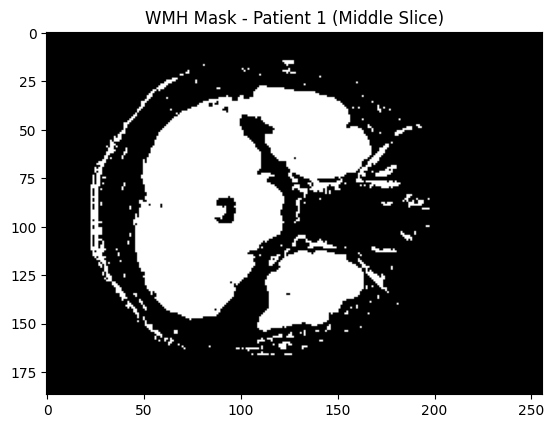

Patient 2: Otsu Threshold Value = 20.92, WMH Volume = 1316513.87 mm³


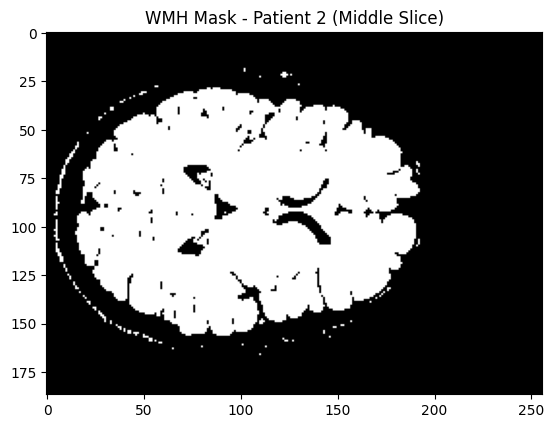

Patient 3: Otsu Threshold Value = 24.50, WMH Volume = 1512177.29 mm³


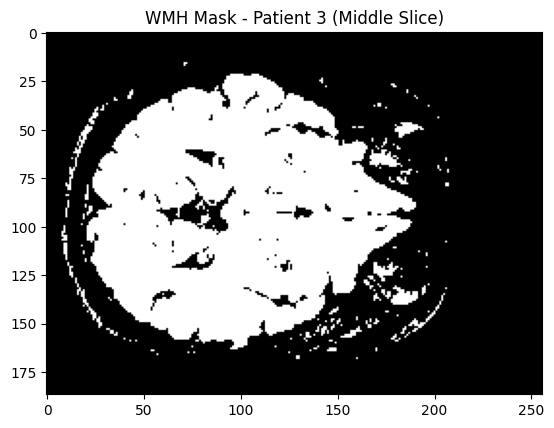

Patient 4: Otsu Threshold Value = 24.35, WMH Volume = 1428420.66 mm³


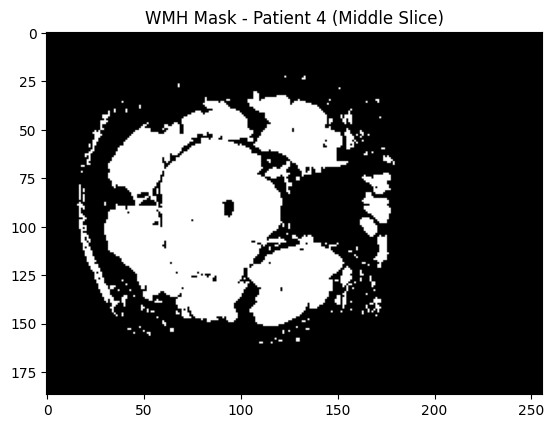

Patient 5: Otsu Threshold Value = 48.10, WMH Volume = 1483426.43 mm³


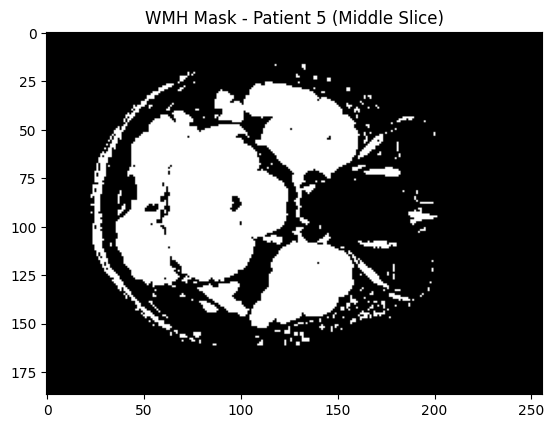

Patient 6: Otsu Threshold Value = 24.71, WMH Volume = 1329399.65 mm³


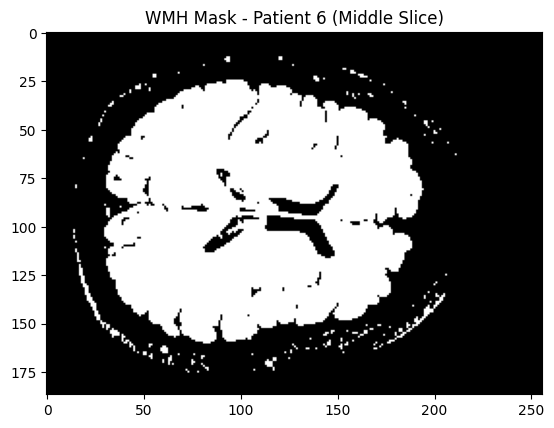

Patient 7: Otsu Threshold Value = 23.78, WMH Volume = 1546148.21 mm³


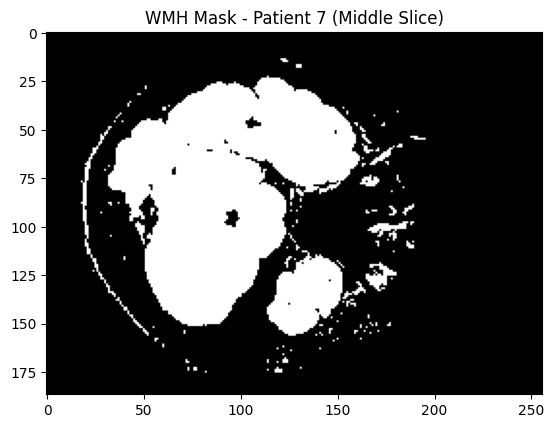

Patient 8: Otsu Threshold Value = 22.35, WMH Volume = 1537274.57 mm³


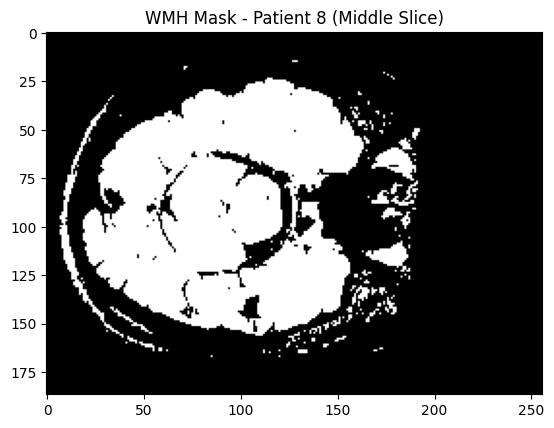

Patient 9: Otsu Threshold Value = 22.29, WMH Volume = 1672877.93 mm³


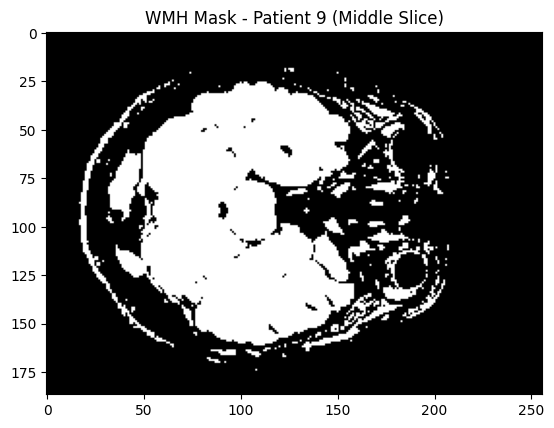

Patient 10: Otsu Threshold Value = 23.38, WMH Volume = 1433829.78 mm³


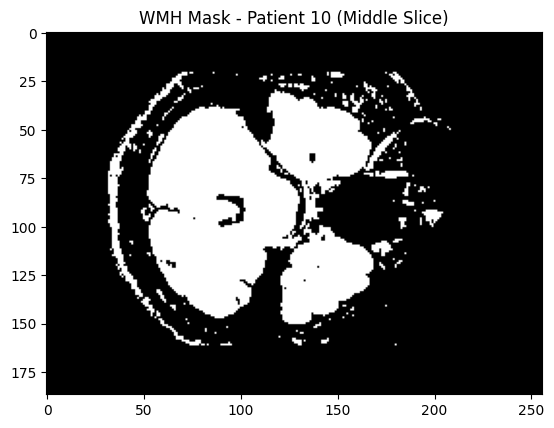

Patient 11: Otsu Threshold Value = 24.81, WMH Volume = 1551169.90 mm³


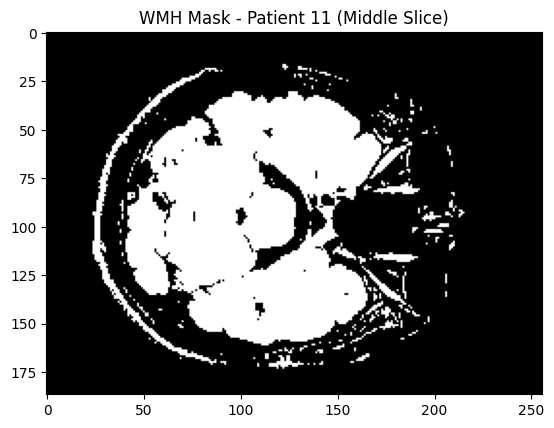

Patient 12: Otsu Threshold Value = 24.58, WMH Volume = 1602478.33 mm³


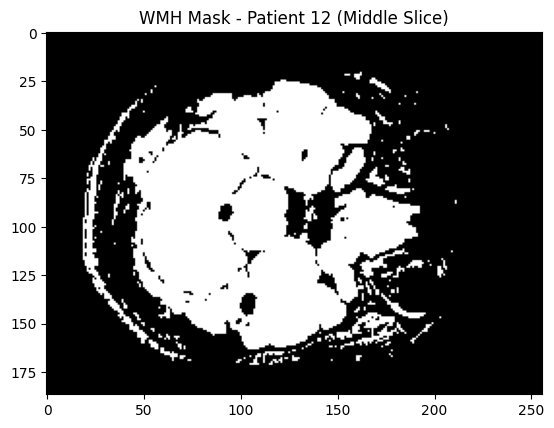


Mean Otsu Threshold Value for all patients = 25.63

WMH Volumes for all patients:
{'Patient_1': 1585190.1844143867, 'Patient_2': 1316513.866186142, 'Patient_3': 1512177.288532257, 'Patient_4': 1428420.6554293633, 'Patient_5': 1483426.4293313026, 'Patient_6': 1329399.6453285217, 'Patient_7': 1546148.2107639313, 'Patient_8': 1537274.569272995, 'Patient_9': 1672877.9301047325, 'Patient_10': 1433829.77694273, 'Patient_11': 1551169.902086258, 'Patient_12': 1602478.3253669739}


In [5]:
# List to store Otsu threshold values for each patient
otsu_thresholds = []
wmh_volumes = {}

# Loop through each patient's folder
for i in range(1, 13):
    # Construct the path for each patient
    patient_dir = os.path.join(base_dir, f'patient_{i}')
    
    # Path to the flair file
    flair_file_path = os.path.join(patient_dir, 'flair.nii.gz')
    
    # Load the FLAIR image
    flair_img = nib.load(flair_file_path)
    flair_data = flair_img.get_fdata()
    
    # Calculate the threshold using Otsu's method
    threshold_value = filters.threshold_otsu(flair_data)
    otsu_thresholds.append(threshold_value)
    
    # Create WMH mask using the threshold
    wmh_mask = flair_data > threshold_value
    
    # Calculate voxel volume from header
    voxel_volume = np.prod(flair_img.header.get_zooms())
    
    # Calculate total WMH volume
    wmh_volume = np.sum(wmh_mask) * voxel_volume
    wmh_volumes[f'Patient_{i}'] = wmh_volume
    
    # Print the threshold value and WMH volume for each patient
    print(f'Patient {i}: Otsu Threshold Value = {threshold_value:.2f}, WMH Volume = {wmh_volume:.2f} mm³')
    
    # Visualize the thresholded WMH mask for a middle slice
    middle_slice = flair_data.shape[2] // 2
    plt.imshow(wmh_mask[:, :, middle_slice], cmap='gray')
    plt.title(f'WMH Mask - Patient {i} (Middle Slice)')
    plt.show()

# Calculate the mean Otsu threshold across all patients
mean_otsu_threshold = np.mean(otsu_thresholds)
print(f'\nMean Otsu Threshold Value for all patients = {mean_otsu_threshold:.2f}')

# Print WMH volumes for all patients
print("\nWMH Volumes for all patients:")
print(wmh_volumes)

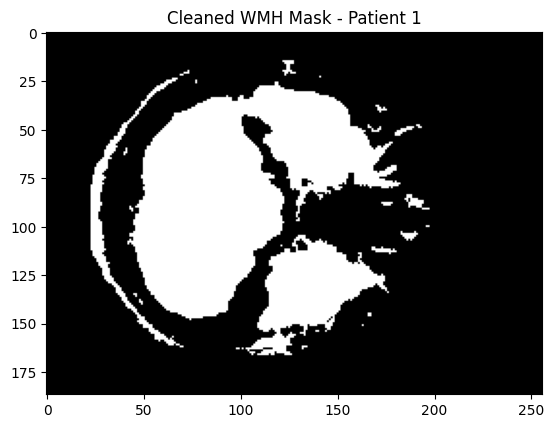

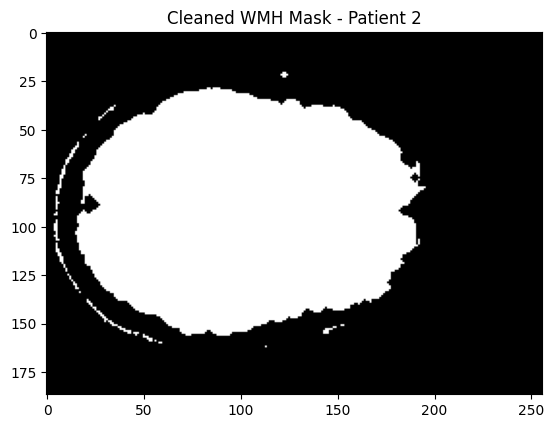

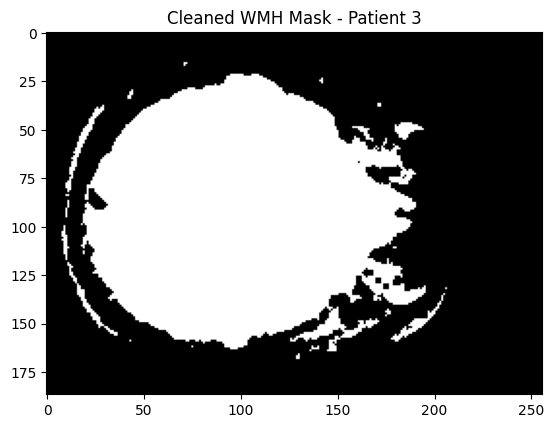

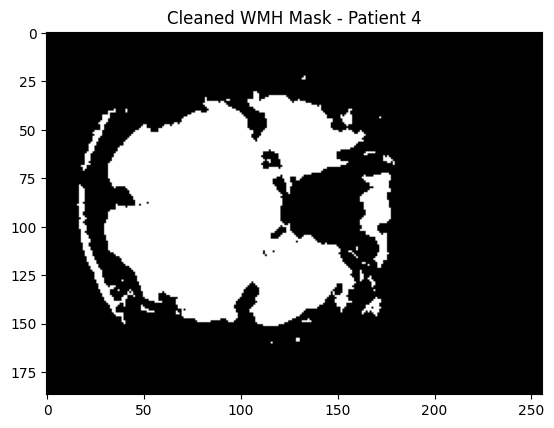

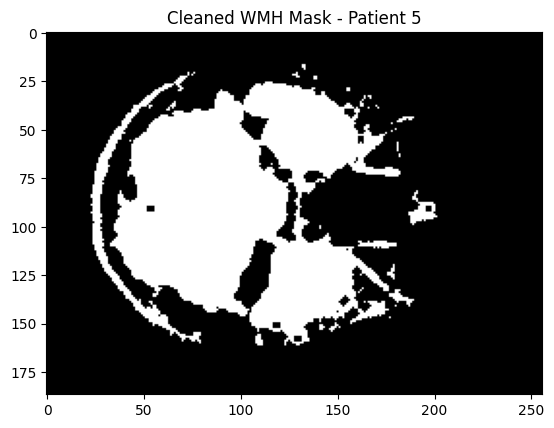

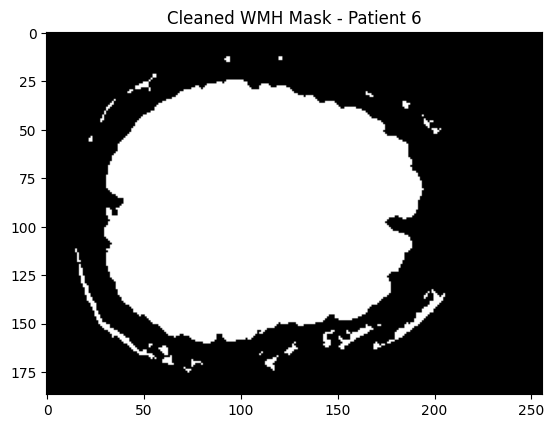

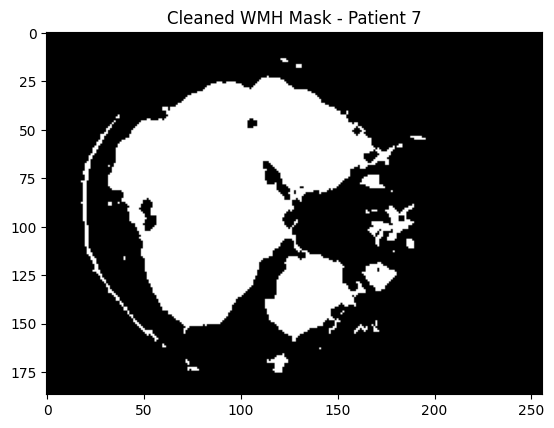

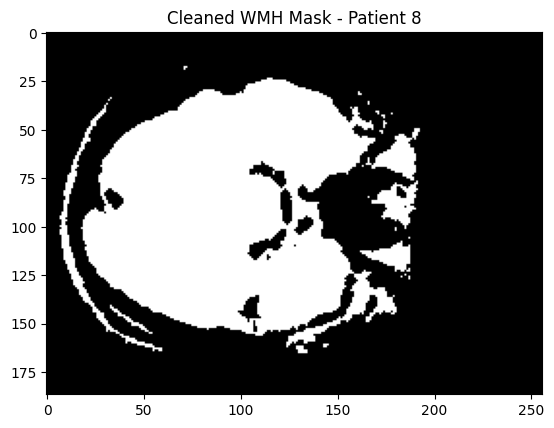

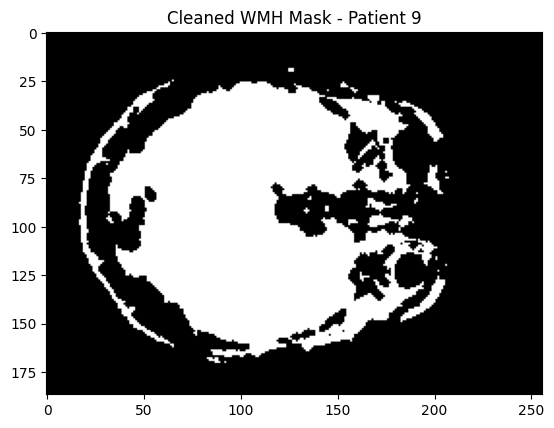

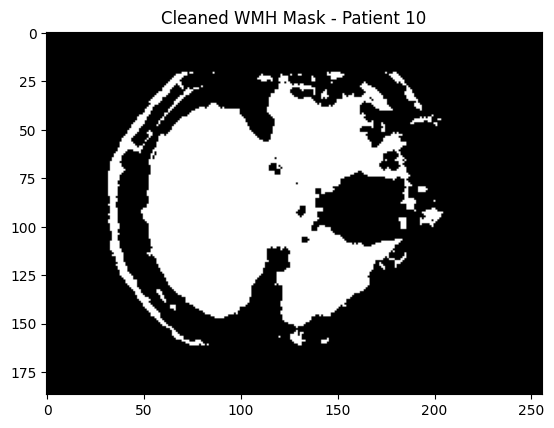

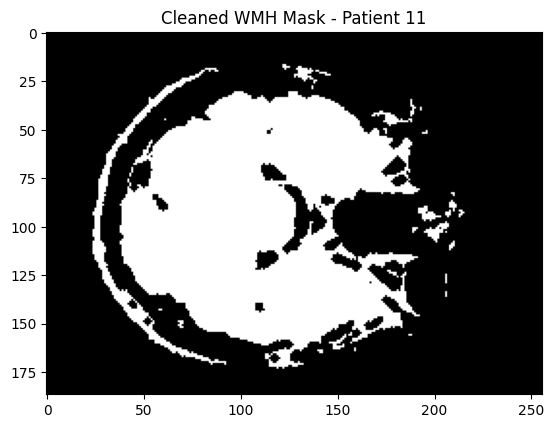

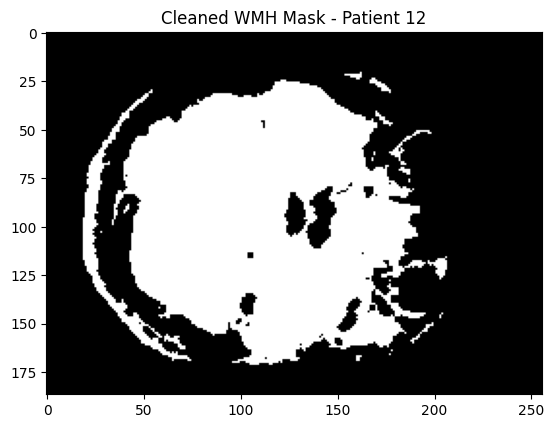

In [8]:
# Loop through each patient's folder
for i in range(1, 13):
    # Construct the path for each patient
    patient_dir = os.path.join(base_dir, f'patient_{i}')
    
    # Path to the flair file
    flair_file_path = os.path.join(patient_dir, 'flair.nii.gz')
    
    # Load the FLAIR image
    flair_img = nib.load(flair_file_path)
    flair_data = flair_img.get_fdata()
    
    # Calculate the threshold using Otsu's method (already done previously)
    threshold_value = filters.threshold_otsu(flair_data)
    
    # Create the initial WMH mask
    wmh_mask = flair_data > threshold_value
    
    # Morphological closing to remove small holes and noise
    wmh_mask_cleaned = morphology.binary_closing(wmh_mask, morphology.ball(2))
    
    # Fill small holes within the mask
    wmh_mask_cleaned = ndimage.binary_fill_holes(wmh_mask_cleaned)
    
    # Remove small objects (noise)
    wmh_mask_cleaned = morphology.remove_small_objects(wmh_mask_cleaned, min_size=64)
    
    # Plot the cleaned WMH mask for the middle slice
    middle_slice = flair_data.shape[2] // 2
    plt.figure()
    plt.imshow(wmh_mask_cleaned[:, :, middle_slice], cmap='gray')
    plt.title(f'Cleaned WMH Mask - Patient {i}')
    plt.show()

In [10]:
import nibabel as nib
import os

# Output directory to save the cleaned WMH masks
output_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through each patient to save the cleaned WMH masks
for i in range(1, 13):
    # Generate the cleaned WMH mask NIfTI image (this assumes 'wmh_mask_cleaned' is already calculated)
    cleaned_wmh_img = nib.Nifti1Image(wmh_mask_cleaned.astype(np.uint8), flair_img.affine)
    
    # Save the cleaned WMH mask with the naming convention patient_i_cleaned_wmh
    output_file_path = os.path.join(output_dir, f'patient_{i}_cleaned_wmh.nii.gz')
    nib.save(cleaned_wmh_img, output_file_path)
    
    # Print confirmation
    print(f'Saved cleaned WMH mask for Patient {i} at: {output_file_path}')

Saved cleaned WMH mask for Patient 1 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_1_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 2 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_2_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 3 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_3_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 4 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_4_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 5 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_5_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 6 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_6_cleaned_wmh.nii.gz
Saved cleaned WMH mask for Patient 7 at: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output/patient_7_cleaned_wmh.nii.gz
Saved 

In [25]:

# Paths to the atlas and base directory for the FLAIR images
atlas_path = '/Users/swapnilbhattacharya/fsl/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr0-1mm.nii.gz'
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD'
output_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Output'

# Load the JHU ICBM white matter atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Define the labels for the regions of interest (ROI) from the atlas
rois = {
    'Cingulate_Cortex': [4, 5],  # Left (4) and Right (5) Cingulate Gyrus
    'Corpus_Callosum': [1, 2, 3],  # Genu (1), Body (2), Splenium (3)
    'SLF': [6, 7]  # Left (6) and Right (7) Superior Longitudinal Fasciculus
}

# Dictionary to store the WMH volumes for each ROI and patient
wmh_roi_volumes = {roi: [] for roi in rois}

# Loop through each patient's FLAIR image and calculate WMH volumes for each ROI
for i in range(1, 13):
    print(f'Calculating WMH volumes for Patient {i}...')
    
    # Paths to the cleaned WMH mask and FLAIR image
    wmh_mask_path = os.path.join(output_dir, f'patient_{i}_cleaned_wmh.nii.gz')
    flair_path = os.path.join(base_dir, f'patient_{i}/flair.nii.gz')
    
    # Load the cleaned WMH mask and FLAIR image
    wmh_mask_img = nib.load(wmh_mask_path)
    wmh_mask_data = wmh_mask_img.get_fdata()
    flair_img = nib.load(flair_path)
    
    # Resample the atlas to match the FLAIR/WMH image dimensions (if necessary)
    if wmh_mask_data.shape != atlas_data.shape:
        resampling_factors = np.array(wmh_mask_data.shape) / np.array(atlas_data.shape)
        atlas_data_resampled = zoom(atlas_data, resampling_factors, order=0)  # Nearest-neighbor interpolation
        print(f"Resampled the atlas to match the WMH mask shape for Patient {i}.")
    else:
        atlas_data_resampled = atlas_data

    # Loop through each ROI and calculate WMH volume
    for roi_name, roi_labels in rois.items():
        # Create a binary mask for the current ROI
        roi_mask = np.isin(atlas_data_resampled, roi_labels)
        
        # Calculate overlap between the ROI and the WMH mask
        wmh_in_roi = np.logical_and(roi_mask, wmh_mask_data)
        
        # Calculate the volume of the WMH in the ROI (voxel count * voxel volume)
        voxel_volume = np.prod(flair_img.header.get_zooms())  # Calculate voxel volume from header
        wmh_volume = np.sum(wmh_in_roi) * voxel_volume
        
        # Store the WMH volume for this ROI and patient
        wmh_roi_volumes[roi_name].append(wmh_volume)
        
        print(f'Patient {i} - {roi_name}: WMH Volume = {wmh_volume:.2f} mm^3')

# Print the final WMH volumes for all patients and ROIs
print("\nFinal WMH Volumes for all patients and ROIs:")
for roi in rois:
    print(f'\n{roi}:')
    for i, wmh_volume in enumerate(wmh_roi_volumes[roi], start=1):
        print(f'Patient {i}: WMH Volume = {wmh_volume:.2f} mm^3')

Calculating WMH volumes for Patient 1...
Resampled the atlas to match the WMH mask shape for Patient 1.
Patient 1 - Cingulate_Cortex: WMH Volume = 68431.72 mm^3
Patient 1 - Corpus_Callosum: WMH Volume = 90091.49 mm^3
Patient 1 - SLF: WMH Volume = 33227.73 mm^3
Calculating WMH volumes for Patient 2...
Resampled the atlas to match the WMH mask shape for Patient 2.
Patient 2 - Cingulate_Cortex: WMH Volume = 68431.72 mm^3
Patient 2 - Corpus_Callosum: WMH Volume = 90091.49 mm^3
Patient 2 - SLF: WMH Volume = 33227.73 mm^3
Calculating WMH volumes for Patient 3...
Resampled the atlas to match the WMH mask shape for Patient 3.
Patient 3 - Cingulate_Cortex: WMH Volume = 68431.72 mm^3
Patient 3 - Corpus_Callosum: WMH Volume = 90091.49 mm^3
Patient 3 - SLF: WMH Volume = 33227.73 mm^3
Calculating WMH volumes for Patient 4...
Resampled the atlas to match the WMH mask shape for Patient 4.
Patient 4 - Cingulate_Cortex: WMH Volume = 68431.72 mm^3
Patient 4 - Corpus_Callosum: WMH Volume = 90091.49 mm^3


In [27]:
# Dictionary to store the mean WMH value for each ROI
mean_wmh_values = {}

# Loop through each ROI and calculate the mean WMH value across patients
for roi_name, wmh_volumes in wmh_roi_volumes.items():
    # Calculate mean WMH volume for the ROI
    mean_wmh = np.mean(wmh_volumes)
    
    # Store the mean WMH value in the dictionary
    mean_wmh_values[roi_name] = mean_wmh


# Print the final mean WMH values for all ROIs
print("\nFinal Mean WMH Values for each Region of Interest (ROI):")
for roi_name, mean_wmh in mean_wmh_values.items():
    print(f'{roi_name}: {mean_wmh:.2f} mm^3')


Final Mean WMH Values for each Region of Interest (ROI):
Cingulate_Cortex: 68431.72 mm^3
Corpus_Callosum: 90091.49 mm^3
SLF: 33227.73 mm^3


In [28]:
# Your calculated WMH values for ASD patients (in mm³)
wmh_values_asd = {
    'Cingulate_Cortex': 68431.72,
    'Corpus_Callosum': 90091.49,
    'SLF': 33227.73
}

# Control group WMH values from literature (in mm³) - estimated
wmh_values_control = {
    'Cingulate_Cortex': 12000,   
    'Corpus_Callosum': 15000,    
    'SLF': 10000                
}

# Dictionary to store the difference (ASD - Control)
wmh_difference = {}

# Loop through each region and compare the values
for region in wmh_values_asd.keys():
    asd_value = wmh_values_asd[region]
    control_value = wmh_values_control[region]
    difference = asd_value - control_value
    wmh_difference[region] = difference
    print(f'{region}:')
    print(f'  ASD WMH Volume = {asd_value:.2f} mm³')
    print(f'  Control WMH Volume = {control_value:.2f} mm³')
    print(f'  Difference (ASD - Control) = {difference:.2f} mm³\n')

# Print the final comparison
print("\nComparison of WMH Volumes (ASD vs Control Group):")
for region, difference in wmh_difference.items():
    print(f'{region}: Difference = {difference:.2f} mm³')

Cingulate_Cortex:
  ASD WMH Volume = 68431.72 mm³
  Control WMH Volume = 12000.00 mm³
  Difference (ASD - Control) = 56431.72 mm³

Corpus_Callosum:
  ASD WMH Volume = 90091.49 mm³
  Control WMH Volume = 15000.00 mm³
  Difference (ASD - Control) = 75091.49 mm³

SLF:
  ASD WMH Volume = 33227.73 mm³
  Control WMH Volume = 10000.00 mm³
  Difference (ASD - Control) = 23227.73 mm³


Comparison of WMH Volumes (ASD vs Control Group):
Cingulate_Cortex: Difference = 56431.72 mm³
Corpus_Callosum: Difference = 75091.49 mm³
SLF: Difference = 23227.73 mm³


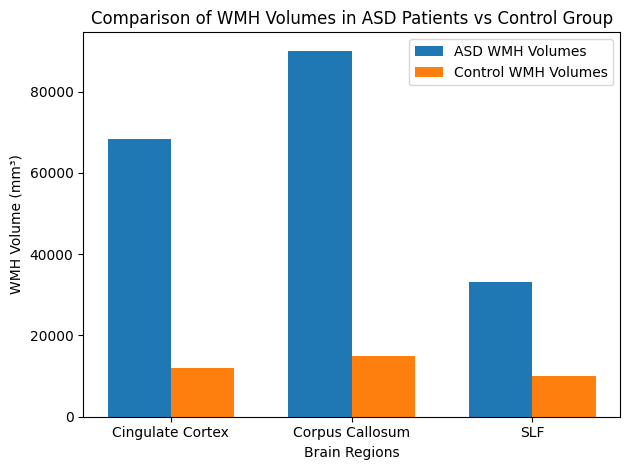

In [29]:
# Data for plotting
regions = ['Cingulate Cortex', 'Corpus Callosum', 'SLF']
asd_wmh = [68431.72, 90091.49, 33227.73]  # WMH volumes for ASD patients
control_wmh = [12000, 15000, 10000]  # Estimated WMH volumes for control group

# Plotting the data
x = np.arange(len(regions))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, asd_wmh, width, label='ASD WMH Volumes')
bars2 = ax.bar(x + width/2, control_wmh, width, label='Control WMH Volumes')

# Labels and title
ax.set_xlabel('Brain Regions')
ax.set_ylabel('WMH Volume (mm³)')
ax.set_title('Comparison of WMH Volumes in ASD Patients vs Control Group')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

FA Statistics

In [30]:
fa_roi_values = {
    'Cingulate_Cortex': [0.5334, 0.5245, 0.5418, 0.5580, 0.5412, 0.4840, 0.5309, 0.5200, 0.5256, 0.5426, 0.5015, 0.5106],
    'Corpus_Callosum': [0.5305, 0.4740, 0.5175, 0.5043, 0.4777, 0.5005, 0.5071, 0.5032, 0.5330, 0.4960, 0.5259, 0.5389],
    'SLF': [0.5579, 0.5250, 0.5387, 0.5630, 0.5146, 0.5673, 0.5216, 0.5502, 0.5722, 0.4921, 0.4972, 0.5495]
}

# Calculate mean FA for each region across the 12 patients
mean_fa_stats = {region: np.mean(fa_values) for region, fa_values in fa_roi_values.items()}

# Print the mean FA values for each region
mean_fa_stats

{'Cingulate_Cortex': 0.5261750000000001,
 'Corpus_Callosum': 0.5090500000000001,
 'SLF': 0.5374416666666667}

In [31]:
mean_fa_asd = {
    'Cingulate_Cortex': 0.5262,
    'Corpus_Callosum': 0.5091,
    'SLF': 0.5374
}

# Control group FA values from literature (mean values)
mean_fa_control = {
    'Cingulate_Cortex': 0.55,   # From literature
    'Corpus_Callosum': 0.55,    # From literature (average across callosal regions)
    'SLF': 0.50                 # From literature
}

# Dictionary to store the differences (ASD - Control)
fa_difference = {}

# Loop through each region and compare the values
for region in mean_fa_asd.keys():
    asd_value = mean_fa_asd[region]
    control_value = mean_fa_control[region]
    difference = asd_value - control_value
    fa_difference[region] = difference
    print(f'{region}:')
    print(f'  ASD Mean FA = {asd_value:.4f}')
    print(f'  Control Mean FA = {control_value:.4f}')
    print(f'  Difference (ASD - Control) = {difference:.4f}\n')

# Print the final comparison
print("\nComparison of Mean FA Values (ASD vs Control Group):")
for region, difference in fa_difference.items():
    print(f'{region}: Difference = {difference:.4f}')

Cingulate_Cortex:
  ASD Mean FA = 0.5262
  Control Mean FA = 0.5500
  Difference (ASD - Control) = -0.0238

Corpus_Callosum:
  ASD Mean FA = 0.5091
  Control Mean FA = 0.5500
  Difference (ASD - Control) = -0.0409

SLF:
  ASD Mean FA = 0.5374
  Control Mean FA = 0.5000
  Difference (ASD - Control) = 0.0374


Comparison of Mean FA Values (ASD vs Control Group):
Cingulate_Cortex: Difference = -0.0238
Corpus_Callosum: Difference = -0.0409
SLF: Difference = 0.0374


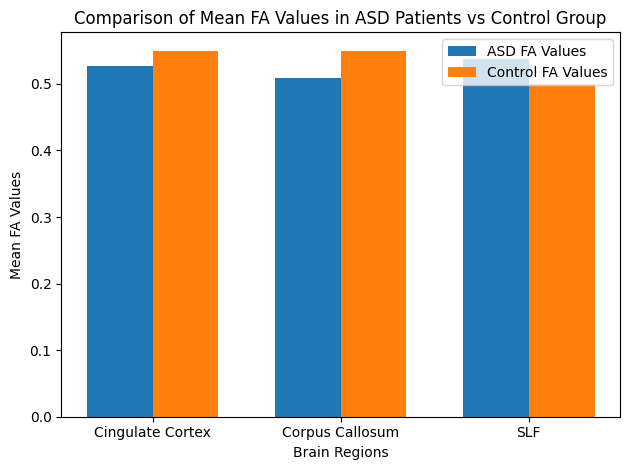

In [32]:
# Data for plotting
regions = ['Cingulate Cortex', 'Corpus Callosum', 'SLF']
asd_fa = [0.5262, 0.5091, 0.5374]  # Mean FA values for ASD patients
control_fa = [0.55, 0.55, 0.50]  # Mean FA values for control group

# Plotting the data
x = np.arange(len(regions))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, asd_fa, width, label='ASD FA Values')
bars2 = ax.bar(x + width/2, control_fa, width, label='Control FA Values')

# Labels and title
ax.set_xlabel('Brain Regions')
ax.set_ylabel('Mean FA Values')
ax.set_title('Comparison of Mean FA Values in ASD Patients vs Control Group')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [3]:
import os

# Base directory where your data is stored
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD'

# List of patients
patients = [f'patient_{i}' for i in range(1, 13)]  # Assuming 12 ASD patients

# Check if files and output directories are present for each patient
for patient in patients:
    print(f'Checking for {patient}...')
    
    # Paths to anat and rest files
    anat_path = os.path.join(base_dir, patient, 'anat.nii.gz')
    rest_path = os.path.join(base_dir, patient, 'rest.nii.gz')
    
    # Path to the output directory
    output_dir = os.path.join(base_dir, patient, 'ML_preprocess')
    
    # 1. Check if anat and rest files are present
    if os.path.isfile(anat_path):
        print(f'  anat.nii.gz is present for {patient}.')
    else:
        print(f'  anat.nii.gz is MISSING for {patient}.')
    
    if os.path.isfile(rest_path):
        print(f'  rest.nii.gz is present for {patient}.')
    else:
        print(f'  rest.nii.gz is MISSING for {patient}.')
    
    # 2. Check if the output directory exists, if not, create it
    if os.path.isdir(output_dir):
        print(f'  ML_preprocess directory exists for {patient}.')
    else:
        print(f'  ML_preprocess directory is MISSING for {patient}. Creating it...')
        os.makedirs(output_dir)
        print(f'  ML_preprocess directory created for {patient}.')
    
    print()  # Add a newline for readability

print("File and directory check completed.")

Checking for patient_1...
  anat.nii.gz is present for patient_1.
  rest.nii.gz is present for patient_1.
  ML_preprocess directory exists for patient_1.

Checking for patient_2...
  anat.nii.gz is present for patient_2.
  rest.nii.gz is present for patient_2.
  ML_preprocess directory exists for patient_2.

Checking for patient_3...
  anat.nii.gz is present for patient_3.
  rest.nii.gz is present for patient_3.
  ML_preprocess directory exists for patient_3.

Checking for patient_4...
  anat.nii.gz is present for patient_4.
  rest.nii.gz is present for patient_4.
  ML_preprocess directory exists for patient_4.

Checking for patient_5...
  anat.nii.gz is present for patient_5.
  rest.nii.gz is present for patient_5.
  ML_preprocess directory exists for patient_5.

Checking for patient_6...
  anat.nii.gz is present for patient_6.
  rest.nii.gz is present for patient_6.
  ML_preprocess directory exists for patient_6.

Checking for patient_7...
  anat.nii.gz is present for patient_7.
  re

In [4]:
base_dir = '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD'
# List of patients
patients = [f'patient_{i}' for i in range(1, 13)]  # Assuming 12 ASD patients

# FSL environment variable for preprocessing commands
fsl_dir = '/Users/swapnilbhattacharya/fsl'
os.environ['FSLDIR'] = fsl_dir
os.environ['PATH'] += f":{fsl_dir}/bin"

# Preprocessing anat and rest files for each patient
for patient in patients:
    print(f'Preprocessing data for {patient}...')
    
    # Paths to anat and rest files
    anat_path = os.path.join(base_dir, patient, 'anat.nii.gz')
    rest_path = os.path.join(base_dir, patient, 'rest.nii.gz')
    
    # Path to the output directory
    output_dir = os.path.join(base_dir, patient, 'ML_preprocess')
    
    # Check if anat and rest files are present
    if not os.path.isfile(anat_path):
        print(f'  anat.nii.gz is MISSING for {patient}. Skipping this patient.')
        continue  # Skip to the next patient if file is missing
    
    if not os.path.isfile(rest_path):
        print(f'  rest.nii.gz is MISSING for {patient}. Skipping this patient.')
        continue  # Skip to the next patient if file is missing
    
    # Ensure the output directory exists, if not, create it
    if not os.path.isdir(output_dir):
        print(f'  ML_preprocess directory is MISSING for {patient}. Creating it...')
        os.makedirs(output_dir)
    
    # 1. Anat Preprocessing
    
    # Skull-stripping using FSL's BET
    skull_stripped_anat = os.path.join(output_dir, 'anat_skull_stripped.nii.gz')
    subprocess.run(['bet', anat_path, skull_stripped_anat, '-R', '-f', '0.5', '-g', '0'])
    
    # Bias field correction using FSL's FAST
    bias_corrected_anat = os.path.join(output_dir, 'anat_bias_corrected.nii.gz')
    subprocess.run(['fast', '-B', skull_stripped_anat, '-o', bias_corrected_anat])
    
    # Spatial normalization using FSL's FLIRT
    normalized_anat = os.path.join(output_dir, 'anat_normalized.nii.gz')
    standard_space = os.path.join(fsl_dir, 'data/standard/MNI152_T1_1mm.nii.gz')
    subprocess.run(['flirt', '-in', bias_corrected_anat, '-ref', standard_space, '-out', normalized_anat])
    
    # 2. Resting-State fMRI Preprocessing
    
    # Motion correction using FSL's MCFLIRT
    motion_corrected_rest = os.path.join(output_dir, 'rest_motion_corrected.nii.gz')
    subprocess.run(['mcflirt', '-in', rest_path, '-out', motion_corrected_rest, '-plots'])
    
    # Slice timing correction using FSL's slicetimer
    slice_time_corrected_rest = os.path.join(output_dir, 'rest_slice_timing_corrected.nii.gz')
    subprocess.run(['slicetimer', '-i', motion_corrected_rest, '-o', slice_time_corrected_rest])
    
    # Spatial normalization of rest to MNI space using FLIRT
    normalized_rest = os.path.join(output_dir, 'rest_normalized.nii.gz')
    subprocess.run(['flirt', '-in', slice_time_corrected_rest, '-ref', standard_space, '-out', normalized_rest])
    
    # Smoothing using Nilearn
    smoothed_rest = os.path.join(output_dir, 'rest_smoothed.nii.gz')
    img = nib.load(normalized_rest)
    smoothed_img = image.smooth_img(img, fwhm=6)  
    smoothed_img.to_filename(smoothed_rest)
    
    print(f'Preprocessing completed for {patient} and saved to {output_dir}.\n')

print("All preprocessing completed.")

Preprocessing data for patient_1...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92037 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.183719 -0.040537 1.385034 -79.326116 
-1.523543 -0.037049 0.211011 265.436879 
0.073799 -1.572565 0.161641 186.649983 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_1 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess.

Preprocessing data for patient_2...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92052 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.139507 -0.042802 -1.611440 251.365719 
1.705820 0.134063 0.199257 -125.120427 
0.025315 -1.691439 0.601962 130.459409 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_2 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ML_preprocess.

Preprocessing data for patient_3...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92067 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.258242 -0.084222 1.447357 -91.834191 
-1.558195 -0.095324 0.297470 267.956360 
0.098858 -1.672205 0.342436 168.091266 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_3 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_3/ML_preprocess.

Preprocessing data for patient_4...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92083 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.108891 -0.015553 -1.531190 260.616286 
1.644265 0.036363 0.146654 -101.308143 
-0.010274 -1.704366 0.445836 166.135353 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_4 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_4/ML_preprocess.

Preprocessing data for patient_5...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92099 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
1.381236 0.030488 -0.029990 -67.700528 
-0.007672 1.266202 0.383609 -75.100535 
0.029012 -0.502675 1.674331 -61.428782 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_5 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_5/ML_preprocess.

Preprocessing data for patient_6...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92114 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.425116 -0.195399 1.365164 -68.052531 
-1.522236 -0.151069 0.444531 260.224517 
0.098939 -1.624277 0.071496 186.160455 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_6 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_6/ML_preprocess.

Preprocessing data for patient_7...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92130 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.111400 -0.047517 1.482343 -79.594269 
-1.538744 0.130421 0.156007 255.891412 
-0.044875 -1.596870 0.303058 193.497761 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_7 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_7/ML_preprocess.

Preprocessing data for patient_8...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92146 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.430093 -0.198776 1.333350 -81.801909 
-1.524184 -0.105549 0.441483 248.290896 
0.059224 -1.581780 0.091754 199.881463 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_8 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_8/ML_preprocess.

Preprocessing data for patient_9...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92164 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Image Exc


Final result: 
0.214067 -0.183137 -1.368004 236.183372 
1.484707 -0.009465 0.315763 -99.483619 
-0.112296 -1.543160 0.371024 187.781040 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_9 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_9/ML_preprocess.

Preprocessing data for patient_10...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92184 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Imag


Final result: 
0.239336 -0.071660 -1.564049 256.051098 
1.644899 0.122148 0.328980 -127.341100 
0.045223 -1.739588 0.429709 186.804575 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_10 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_10/ML_preprocess.

Preprocessing data for patient_11...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92206 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Imag


Final result: 
0.203008 -0.002274 1.552031 -107.950398 
-1.587059 0.124087 0.187446 262.529722 
-0.074257 -1.619110 0.344443 198.531598 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_11 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_11/ML_preprocess.

Preprocessing data for patient_12...

Error: input image /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/anat not valid



Image Exception : #63 :: No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess/anat_bias_corrected
Image Exception : #22 :: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess/anat_bias_corrected
libc++abi: terminating due to uncaught exception of type std::runtime_error: Failed to read volume /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess/anat_bias_corrected.nii.gz
Error : No image files match: /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess/anat_bias_corrected
/Users/swapnilbhattacharya/fsl/share/fsl/bin/fast: line 2: 92222 Abort trap: 6           /Users/swapnilbhattacharya/fsl/bin/fast "$@"
Imag


Final result: 
0.248392 -0.087854 1.397851 -75.640747 
-1.595896 0.181655 0.227435 257.395566 
-0.127862 -1.578282 0.247785 211.430383 
0.000000 0.000000 0.000000 1.000000 

Preprocessing completed for patient_12 and saved to /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_12/ML_preprocess.

All preprocessing completed.


In [5]:
# List of patients
patients = [f'patient_{i}' for i in range(1, 13)]  # Assuming 12 ASD patients

# List of expected preprocessed files
expected_files = [
    'anat_skull_stripped.nii.gz',
    'anat_bias_corrected.nii.gz',
    'anat_normalized.nii.gz',
    'rest_motion_corrected.nii.gz',
    'rest_slice_timing_corrected.nii.gz',
    'rest_normalized.nii.gz',
    'rest_smoothed.nii.gz'
]

# Check for the presence of preprocessed files and their sizes
for patient in patients:
    print(f'Checking files for {patient}...')
    
    # Path to the output directory
    output_dir = os.path.join(base_dir, patient, 'ML_preprocess')
    
    # Check if the output directory exists
    if not os.path.isdir(output_dir):
        print(f'  ML_preprocess directory is MISSING for {patient}.')
        continue
    
    # Loop through expected files and check for their presence and file size
    for file_name in expected_files:
        file_path = os.path.join(output_dir, file_name)
        
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # File size in MB
            print(f'  {file_name} is present. File size: {file_size:.2f} MB')
        else:
            print(f'  {file_name} is MISSING for {patient}.')
    
    print()  # Add a newline for readability

print("File check completed.")

Checking files for patient_1...
  anat_skull_stripped.nii.gz is MISSING for patient_1.
  anat_bias_corrected.nii.gz is MISSING for patient_1.
  anat_normalized.nii.gz is MISSING for patient_1.
  rest_motion_corrected.nii.gz is present. File size: 84.99 MB
  rest_slice_timing_corrected.nii.gz is present. File size: 86.64 MB
  rest_normalized.nii.gz is present. File size: 24.58 MB
  rest_smoothed.nii.gz is present. File size: 24.60 MB

Checking files for patient_2...
  anat_skull_stripped.nii.gz is MISSING for patient_2.
  anat_bias_corrected.nii.gz is MISSING for patient_2.
  anat_normalized.nii.gz is MISSING for patient_2.
  rest_motion_corrected.nii.gz is present. File size: 84.96 MB
  rest_slice_timing_corrected.nii.gz is present. File size: 86.39 MB
  rest_normalized.nii.gz is present. File size: 24.15 MB
  rest_smoothed.nii.gz is present. File size: 24.43 MB

Checking files for patient_3...
  anat_skull_stripped.nii.gz is MISSING for patient_3.
  anat_bias_corrected.nii.gz is MISSI

In [7]:
# List of patients
patients = [f'patient_{i}' for i in range(1, 13)]  

# FSL environment variable for preprocessing commands
fsl_dir = '/usr/local/fsl'  # Adjust based on your system setup
os.environ['FSLDIR'] = fsl_dir
os.environ['PATH'] += f":{fsl_dir}/bin"

# Preprocessing anat files for each patient
for patient in patients:
    print(f'Preprocessing anat file for {patient}...')
    
    # Path to anat file
    anat_path = os.path.join(base_dir, patient, 'anat.nii.gz')
    
    # Check if the anat file exists
    if not os.path.isfile(anat_path):
        print(f'  anat.nii.gz is MISSING for {patient}. Skipping this patient.')
        continue  
    
    # Path to the output directory (ML_preprocess folder)
    output_dir = os.path.join(base_dir, patient, 'ML_preprocess')
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    try:
        # 1. Skull-Stripping using FSL's BET
        skull_stripped_anat = os.path.join(output_dir, 'anat_skull_stripped.nii.gz')
        print(f'  Performing skull-stripping for {patient}...')
        subprocess.run(['bet', anat_path, skull_stripped_anat, '-R', '-f', '0.5', '-g', '0'], check=True)
    
        # 2. Bias Field Correction using FSL's FAST
        bias_corrected_anat = os.path.join(output_dir, 'anat_bias_corrected.nii.gz')
        print(f'  Performing bias field correction for {patient}...')
        subprocess.run(['fast', '-B', skull_stripped_anat, '-o', bias_corrected_anat], check=True)
    
        # 3. Spatial Normalization using FSL's FLIRT
        normalized_anat = os.path.join(output_dir, 'anat_normalized.nii.gz')
        standard_space = os.path.join(fsl_dir, 'data/standard/MNI152_T1_1mm.nii.gz')
        print(f'  Performing spatial normalization for {patient}...')
        subprocess.run(['flirt', '-in', bias_corrected_anat, '-ref', standard_space, '-out', normalized_anat], check=True)
    
        print(f'Preprocessing completed for {patient}. Files stored in {output_dir}.\n')

    except subprocess.CalledProcessError as e:
        print(f"Error occurred during preprocessing for {patient}: {e}")
        print(f"Command output: {e.output}\n")

print("Anat preprocessing for all patients completed.")

Preprocessing anat file for patient_1...
  Performing skull-stripping for patient_1...
/Users/swapnilbhattacharya/fsl/bin/bet failed during command:/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/anat.nii.gz /Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_skull_stripped.nii.gz -R -f 0.5 -g 0
Error occurred during preprocessing for patient_1: Command '['bet', '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/anat.nii.gz', '/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_skull_stripped.nii.gz', '-R', '-f', '0.5', '-g', '0']' returned non-zero exit status 1.
Command output: None

Preprocessing anat file for patient_2...
  Performing skull-stripping for patient_2...
/Users/swapnilbhattacharya/fsl/bin/bet failed during command:/Users/swapnilbhattacharya/Desktop/White Matter Hyperintensities/Data/ASD/patient_2/ana

/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /usr/local/fsl/bin/remove_ext: No such file or directory
/Users/swapnilbhattacharya/fsl/bin/be

In [3]:
base_dir = '/Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Data/ASD'
# List of patients
patients = [f'patient_{i}' for i in range(1, 13)]  # Assuming 12 ASD patients

# FSL environment variable for preprocessing commands
fsl_dir = '/Users/swapnilbhattacharya/fsl/data/standard/fsl'
os.environ['FSLDIR'] = fsl_dir
os.environ['PATH'] += f":{fsl_dir}/bin"

# Preprocessing anat and rest files for each patient
for patient in patients:
    print(f'Preprocessing data for {patient}...')
    
    # Paths to anat and rest files
    anat_path = os.path.join(base_dir, patient, 'anat.nii.gz')
    rest_path = os.path.join(base_dir, patient, 'rest.nii.gz')
    
    # Path to the output directory
    output_dir = os.path.join(base_dir, patient, 'ML_preprocess')
    
    # Check if anat and rest files are present
    if not os.path.isfile(anat_path):
        print(f'  anat.nii.gz is MISSING for {patient}. Skipping this patient.')
        continue  # Skip to the next patient if file is missing
    
    if not os.path.isfile(rest_path):
        print(f'  rest.nii.gz is MISSING for {patient}. Skipping this patient.')
        continue  # Skip to the next patient if file is missing
    
    # Ensure the output directory exists, if not, create it
    if not os.path.isdir(output_dir):
        print(f'  ML_preprocess directory is MISSING for {patient}. Creating it...')
        os.makedirs(output_dir)
    
    # 1. Anat Preprocessing
    
    # Skull-stripping using FSL's BET
    skull_stripped_anat = os.path.join(output_dir, 'anat_skull_stripped.nii.gz')
    subprocess.run(['bet', anat_path, skull_stripped_anat, '-R', '-f', '0.5', '-g', '0'])
    
    # Bias field correction using FSL's FAST
    bias_corrected_anat = os.path.join(output_dir, 'anat_bias_corrected.nii.gz')
    subprocess.run(['fast', '-B', skull_stripped_anat, '-o', bias_corrected_anat])
    
    # Spatial normalization using FSL's FLIRT
    normalized_anat = os.path.join(output_dir, 'anat_normalized.nii.gz')
    standard_space = os.path.join(fsl_dir, 'data/standard/MNI152_T1_1mm.nii.gz')
    subprocess.run(['flirt', '-in', bias_corrected_anat, '-ref', standard_space, '-out', normalized_anat])
    
    # 2. Resting-State fMRI Preprocessing
    
    # Motion correction using FSL's MCFLIRT
    motion_corrected_rest = os.path.join(output_dir, 'rest_motion_corrected.nii.gz')
    subprocess.run(['mcflirt', '-in', rest_path, '-out', motion_corrected_rest, '-plots'])
    
    # Slice timing correction using FSL's slicetimer
    slice_time_corrected_rest = os.path.join(output_dir, 'rest_slice_timing_corrected.nii.gz')
    subprocess.run(['slicetimer', '-i', motion_corrected_rest, '-o', slice_time_corrected_rest])
    
    # Spatial normalization of rest to MNI space using FLIRT
    normalized_rest = os.path.join(output_dir, 'rest_normalized.nii.gz')
    subprocess.run(['flirt', '-in', slice_time_corrected_rest, '-ref', standard_space, '-out', normalized_rest])
    
    # Smoothing using Nilearn
    smoothed_rest = os.path.join(output_dir, 'rest_smoothed.nii.gz')
    img = nib.load(normalized_rest)
    smoothed_img = image.smooth_img(img, fwhm=6)  
    smoothed_img.to_filename(smoothed_rest)
    
    print(f'Preprocessing completed for {patient} and saved to {output_dir}.\n')

print("All preprocessing completed.")

Preprocessing data for patient_1...
/Users/swapnilbhattacharya/fsl/bin/bet failed during command:/Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Data/ASD/patient_1/anat.nii.gz /Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Data/ASD/patient_1/ML_preprocess/anat_skull_stripped.nii.gz -R -f 0.5 -g 0


/Users/swapnilbhattacharya/fsl/bin/bet: line 157: /Users/swapnilbhattacharya/fsl/data/standard/fsl/bin/remove_ext: No such file or directory


In [10]:
import nibabel as nib
import numpy as np
import os
from dipy.align.reslice import reslice

# Paths to the FA maps and the atlas
fa_map_dir = "/Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Output"  
atlas_path = "/Users/swapnilbhattacharya/fsl/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr0-1mm.nii.gz"  
output_dir = "/Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Output"  

# Define the regions of interest (ROIs) by their labels in the JHU White Matter Tractography Atlas
rois = {
    'Cingulate_Cortex': [33, 34],  # Left and Right Cingulum
    'Corpus_Callosum': [1, 3],     # Genu and Splenium of Corpus Callosum
    'SLF': [17, 18],               # Left and Right Superior Longitudinal Fasciculus
}

# Function to resample the atlas to the FA map's resolution and shape
def resample_to_fa(fa_img, atlas_img):
    # Get FA and atlas data
    fa_data = fa_img.get_fdata()
    fa_affine = fa_img.affine
    fa_voxel_size = fa_img.header.get_zooms()[:3]

    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    atlas_voxel_size = atlas_img.header.get_zooms()[:3]

    # Resample atlas to match FA map resolution and shape
    atlas_resampled_data, atlas_resampled_affine = reslice(atlas_data, atlas_affine, atlas_voxel_size, fa_voxel_size, order=1)
    
    # Ensure the resampled atlas has the same shape as the FA data
    if atlas_resampled_data.shape != fa_data.shape:
        atlas_resampled_data = np.resize(atlas_resampled_data, fa_data.shape)
    
    return atlas_resampled_data

# Function to calculate the volume for a given ROI
def calculate_roi_volume(fa_data, atlas_data, roi_labels):
    roi_mask = np.isin(atlas_data, roi_labels)
    
    # Ensure the mask is the same shape as the FA data
    if roi_mask.shape != fa_data.shape:
        raise ValueError("ROI mask and FA data shape mismatch.")
    
    roi_volume = np.sum(fa_data[roi_mask])  
    return roi_volume

# Initialize a dictionary to store the volumes for each patient
patients_roi_volumes = {}

# Loop through the FA maps for each patient
for patient_id in range(1, 13):
    fa_map_path = os.path.join(fa_map_dir, f"patient_{patient_id}_fa_map.nii.gz")
    
    if not os.path.exists(fa_map_path):
        print(f"FA map for patient {patient_id} not found. Skipping.")
        continue
    
    # Load the FA map for the patient
    fa_img = nib.load(fa_map_path)
    
    # Load the atlas and resample it to match the FA map resolution
    atlas_img = nib.load(atlas_path)
    atlas_resampled_data = resample_to_fa(fa_img, atlas_img)
    
    # Get the FA data from the FA map
    fa_data = fa_img.get_fdata()
    
    # Calculate the volume for each ROI
    patient_volumes = {}
    for roi_name, roi_labels in rois.items():
        left_volume = calculate_roi_volume(fa_data, atlas_resampled_data, [roi_labels[0]])  # Left hemisphere
        right_volume = calculate_roi_volume(fa_data, atlas_resampled_data, [roi_labels[1]])  # Right hemisphere
        patient_volumes[roi_name] = (left_volume, right_volume)
    
    patients_roi_volumes[f'Patient_{patient_id}'] = patient_volumes
    print(f"Volumes for Patient {patient_id}: {patient_volumes}")

# Save the ROI volumes to a file
output_file = os.path.join(output_dir, "roi_volumes.npy")
np.save(output_file, patients_roi_volumes)

print("ROI volumes calculated and saved.")

Volumes for Patient 1: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2753.1214003881296, 2453.669748629656), 'SLF': (247.39769039201303, 648.9295793835121)}
Volumes for Patient 2: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2849.484560123115, 2560.093848866982), 'SLF': (283.61821926449835, 775.1970649959594)}
Volumes for Patient 3: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2914.021625665111, 2527.052126488471), 'SLF': (360.44751540816594, 673.6665630242707)}
Volumes for Patient 4: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2888.819608520988, 2491.840767985803), 'SLF': (311.2047216323425, 655.1457224106292)}
Volumes for Patient 5: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2697.556194334287, 2484.2503338409806), 'SLF': (236.21778098288246, 561.6279555378903)}
Volumes for Patient 6: {'Cingulate_Cortex': (0.0, 0.0), 'Corpus_Callosum': (2914.155015248948, 2535.2420514559763), 'SLF': (332.2980722442285, 710.5840221471146)}
Volumes for Patient 7

In [11]:

patients_roi_volumes = {
    'Patient_1': {'Corpus_Callosum': (2753.12, 2453.67), 'SLF': (247.40, 648.93)},
    'Patient_2': {'Corpus_Callosum': (2849.48, 2560.09), 'SLF': (283.62, 775.20)},
    'Patient_3': {'Corpus_Callosum': (2914.02, 2527.05), 'SLF': (360.45, 673.67)},
    'Patient_4': {'Corpus_Callosum': (2888.82, 2491.84), 'SLF': (311.20, 655.15)},
    'Patient_5': {'Corpus_Callosum': (2697.56, 2484.25), 'SLF': (236.22, 561.63)},
    'Patient_6': {'Corpus_Callosum': (2914.16, 2535.24), 'SLF': (332.30, 710.58)},
    'Patient_7': {'Corpus_Callosum': (2745.17, 2516.87), 'SLF': (261.94, 465.97)},
    'Patient_8': {'Corpus_Callosum': (2911.28, 2499.05), 'SLF': (357.74, 882.00)},
    'Patient_9': {'Corpus_Callosum': (2702.14, 2448.04), 'SLF': (267.69, 710.52)},
    'Patient_10': {'Corpus_Callosum': (2739.71, 2506.46), 'SLF': (256.96, 659.85)},
    'Patient_11': {'Corpus_Callosum': (2588.84, 2310.32), 'SLF': (262.43, 575.46)},
    'Patient_12': {'Corpus_Callosum': (2679.79, 2432.46), 'SLF': (254.78, 605.09)},
}

# Function to calculate AI
def calculate_ai(left_volume, right_volume):
    if left_volume + right_volume == 0:
        return np.nan  # Handle cases where both volumes are zero
    return ((left_volume - right_volume) / (left_volume + right_volume)) * 100

# Calculate AI for each patient and each region
patient_ais = {}
mean_ais = {'Corpus_Callosum': [], 'SLF': []}

for patient, volumes in patients_roi_volumes.items():
    patient_ai = {}
    for roi_name, (left_volume, right_volume) in volumes.items():
        ai = calculate_ai(left_volume, right_volume)
        patient_ai[roi_name] = ai
        if not np.isnan(ai):
            mean_ais[roi_name].append(ai)
    patient_ais[patient] = patient_ai

# Calculate mean AI for each ROI across all patients
mean_ai_results = {roi: np.nanmean(ais) for roi, ais in mean_ais.items()}

# Print the results
for patient, ais in patient_ais.items():
    print(f"Asymmetry Indices for {patient}: {ais}")

print("\nMean Asymmetry Index across all patients:")
print(mean_ai_results)

Asymmetry Indices for Patient_1: {'Corpus_Callosum': 5.751144179043131, 'SLF': -44.79711713319871}
Asymmetry Indices for Patient_2: {'Corpus_Callosum': 5.34959340576053, 'SLF': -46.42715475718252}
Asymmetry Indices for Patient_3: {'Corpus_Callosum': 7.112020246017783, 'SLF': -30.288554519784938}
Asymmetry Indices for Patient_4: {'Corpus_Callosum': 7.377905312731152, 'SLF': -35.592694158431215}
Asymmetry Indices for Patient_5: {'Corpus_Callosum': 4.11651527169078, 'SLF': -40.785862004136106}
Asymmetry Indices for Patient_6: {'Corpus_Callosum': 6.953426065254892, 'SLF': -36.27262964099417}
Asymmetry Indices for Patient_7: {'Corpus_Callosum': 4.3386215232115335, 'SLF': -28.029564094462227}
Asymmetry Indices for Patient_8: {'Corpus_Callosum': 7.619313424504605, 'SLF': -42.28789907561263}
Asymmetry Indices for Patient_9: {'Corpus_Callosum': 4.933808138744663, 'SLF': -45.26942067654184}
Asymmetry Indices for Patient_10: {'Corpus_Callosum': 4.446100679162131, 'SLF': -43.944765000381764}
Asymm

/var/folders/k4/86f1bq0120jd056173p5mdw40000gn/T/ipykernel_4356/607030181.py:29: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  prefrontal_mask_img = image.new_img_like(atlas_img, prefrontal_mask_data)
/Users/swapnilbhattacharya/anaconda3/envs/Autism-ADHD/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/swapnilbhattacharya/anaconda3/envs/Autism-ADHD/lib/python3.8/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int32 to float32
  return resample_img(
/Users/swapnilbhattacharya/anaconda3/envs/Autism-ADHD/lib/python3.8/site-packages/nilearn/image/resampling.py:293: UserWarni


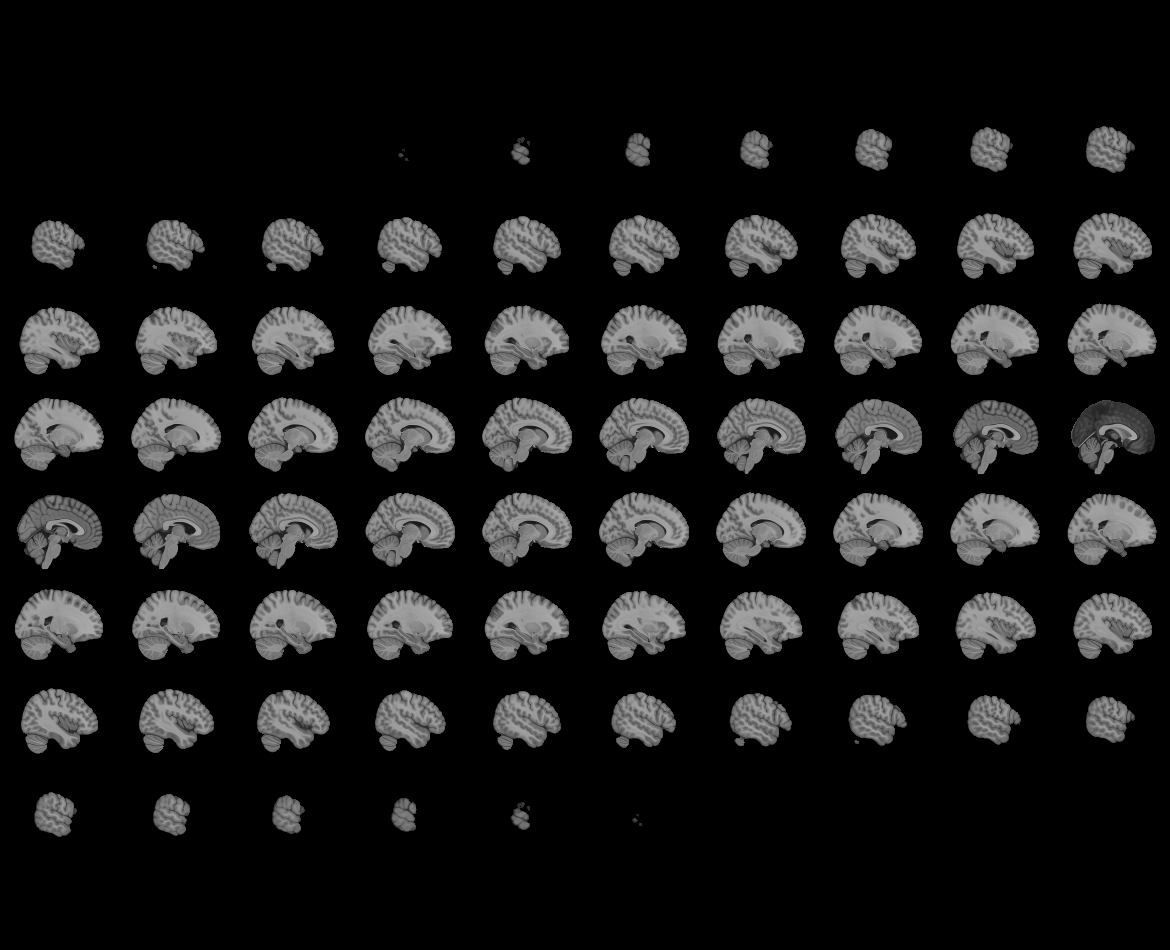
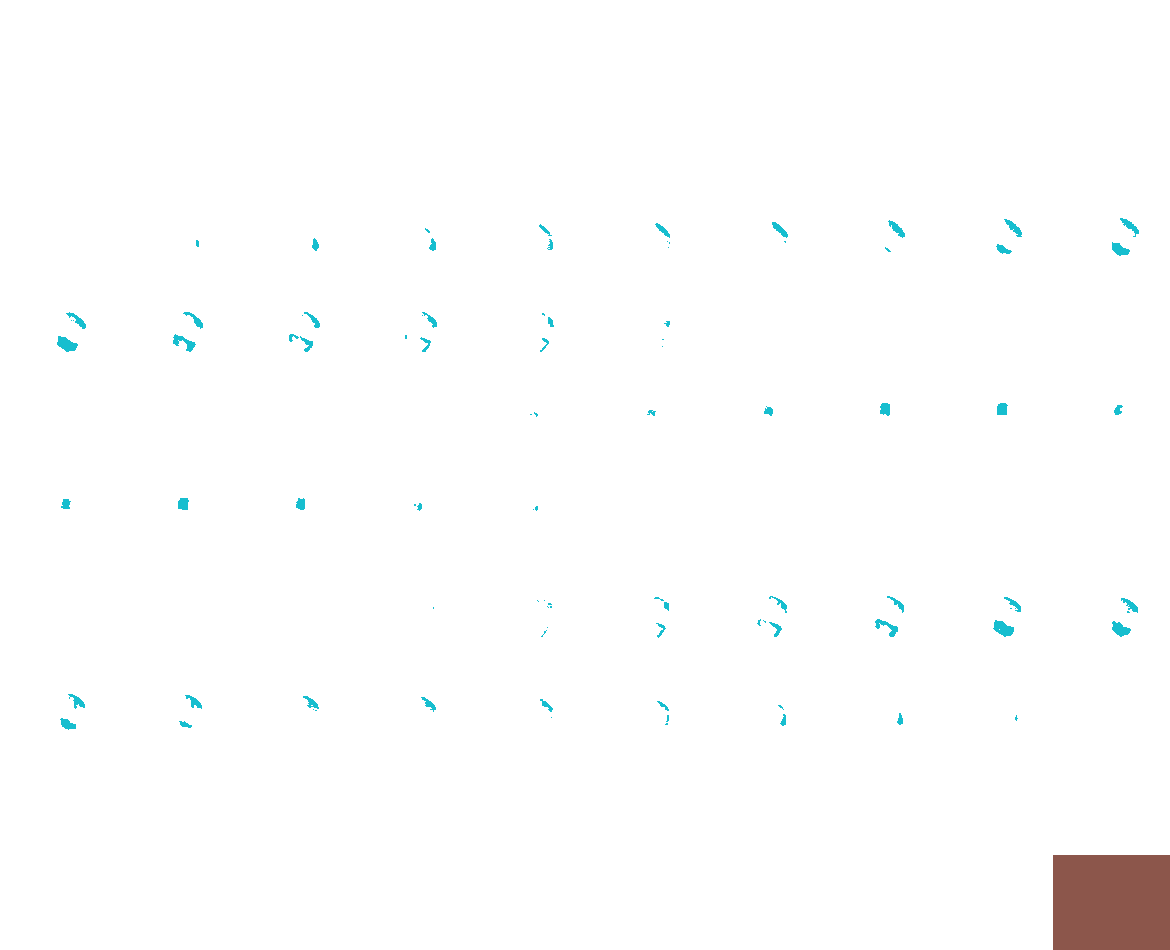

In [3]:
from nilearn import plotting
from nilearn import datasets, image
import numpy as np

# Download the Harvard-Oxford atlas and load the atlas with labels
harvard_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-1mm')

# Define the labels for the prefrontal cortex (superior frontal gyrus, middle frontal gyrus, etc.)
prefrontal_labels = [
    'Frontal Pole', 
    'Superior Frontal Gyrus', 
    'Middle Frontal Gyrus', 
    'Frontal Medial Cortex'
]

# Create a mask for the prefrontal cortex regions
prefrontal_indices = [i for i, label in enumerate(harvard_atlas.labels) if label in prefrontal_labels]

# Load the atlas image
atlas_img = image.load_img(harvard_atlas.maps)

# Create a mask for the prefrontal cortex regions
prefrontal_mask_data = np.zeros(atlas_img.shape, dtype=int)

for idx in prefrontal_indices:
    prefrontal_mask_data[atlas_img.get_fdata() == idx + 1] = 1

# Create a new Nifti image for the prefrontal cortex mask
prefrontal_mask_img = image.new_img_like(atlas_img, prefrontal_mask_data)

# Plot the prefrontal cortex in 3D
plotting.view_img(prefrontal_mask_img, title="Prefrontal Cortex (3D)", cmap='tab10')

In [5]:
!pip3 install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 32.6 MB/s eta 0:00:0000:0100:01


In [6]:
import cv2
import numpy as np
import nibabel as nib

In [8]:
import nibabel as nib
import numpy as np

# Load NIfTI images
def load_nii_image(filepath):
    img = nib.load(filepath)
    img_data = img.get_fdata()
    return img_data

def mse(imageA, imageB):
    # Compute MSE between two 3D volumes
    return np.mean((imageA - imageB) ** 2)

# Load the two images
image1 = load_nii_image('/Users/swapnilbhattacharya/Desktop/White-Matter-Hyperintensities/Data/ASD/patient_1/rest.nii.gz')
image2 = load_nii_image('/Users/swapnilbhattacharya/Documents/Dissertation_Autism_and_ADHD/ADHD200/Brown_26001_1/rest_1/NIfTI/rest.nii.gz')

# Print the dimensions of the two images
print(f"Shape of image1: {image1.shape}")
print(f"Shape of image2: {image2.shape}")

# Ensure the dimensions match
if image1.shape != image2.shape:
    raise ValueError("The images do not have the same dimensions.")

# Calculate the MSE
mse_value = mse(image1, image2)
print(f"MSE between the two images: {mse_value}")

Shape of image1: (64, 64, 50, 120)
Shape of image2: (64, 64, 35, 251)


ValueError: The images do not have the same dimensions.